In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/Users/marcellamirabelli/Desktop/rbp_localization_project/models/RUFF_KING_Grammars_of_IDRs_using_NARDINI-/Notebooks/step2_idrs_with_locations.csv")


# clean
df = df.dropna(subset=["Cluster Number", "location"]).copy()
df["Cluster Number"] = df["Cluster Number"].astype(int)
df = df[df["IDR Length"] >= 70].copy()

print("After filtering:", df.shape)
df.head(3)


After filtering: (8715, 9)


,gene_name,location,Genes,Uniprot,Cluster Number,Start Pos,End Pos,IDR Length,Sequence
4,AFAP1,Actin filaments,AFAP1 IDR5,Q8N556,25,656.0,730.0,74.0,IEPKSGTSSPQSPVFRHRTLENSPISSCDTSDTEGPVPVNSAAVLK...
5,ARSJ,Actin filaments,ARSJ IDR1,Q5FYB0,23,529.0,599.0,70.0,AVPVRYPPKDPRSNPRLNGGVWGPWYKEETKKKKPSKNQAEKKQKK...
6,AVEN,Actin filaments,AVEN IDR1,Q9NQS1,0,0.0,117.0,117.0,MQAERGARGGRGRRPGRGRPGGDRHSERPGAAAAVARGGGGGGGGD...


In [3]:
clusters = sorted(df["Cluster Number"].unique())
locations = sorted(df["location"].unique())

rows = []
for loc in locations:
    for cl in clusters:
        a = len(df[(df["Cluster Number"]==cl) & (df["location"]==loc)])
        b = len(df[(df["Cluster Number"]!=cl) & (df["location"]==loc)])
        c = len(df[(df["Cluster Number"]==cl) & (df["location"]!=loc)])
        d = len(df[(df["Cluster Number"]!=cl) & (df["location"]!=loc)])
        _, p = fisher_exact([[a,b],[c,d]], alternative="greater")
        rows.append((loc, cl, a, b, c, d, p))

res_df = pd.DataFrame(rows, columns=["location","cluster","a","b","c","d","p_raw"])
res_df["neglog10_p_raw"] = -np.log10(res_df["p_raw"].replace(0, np.nextafter(0,1)))
res_df.head(3)


,location,cluster,a,b,c,d,p_raw,neglog10_p_raw
0,Actin filaments,0,1,85,217,8412,0.888019,0.051578
1,Actin filaments,1,6,80,305,8324,0.086300,1.063987
2,Actin filaments,2,0,86,90,8539,1.000000,-0.000000


In [4]:
pivot = res_df.pivot(index="location", columns="cluster", values="neglog10_p_raw")
pivot.head(3)


cluster,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
location,,,,,,,,,,,,,,,,,,,,,
Actin filaments,0.051578,1.063987,-0.0,0.004063,0.205248,0.539208,0.050284,-0.000000,0.483089,0.539098,...,0.159562,-0.000000,-0.0,0.326822,0.256286,0.523761,0.109591,0.037879,0.062030,0.040254
Cell Junctions,0.008561,0.733179,-0.0,0.245738,0.031939,0.068695,0.020229,0.007952,-0.000000,0.389290,...,0.094743,0.154155,-0.0,0.054687,0.420376,0.725394,0.126303,0.068553,2.532841,2.725383
Centriolar satellite,0.097751,0.045998,-0.0,0.947075,0.689030,0.397008,0.287594,0.094547,0.672758,0.381068,...,0.080819,-0.000000,-0.0,0.031997,0.841201,0.625728,0.176285,0.096149,1.243734,0.100513


In [5]:
# Y-axis (your order)
loc_order = [
    "Nucleoplasm",
    "Nuclear speckles",
    "Nucleoli",
    "Nucleoli rim",
    "Nuclear bodies",
    "Actin filaments",
    "Cell Junctions",
    "Nucleoli fibrillar center",
    "Intermediate filaments",
    "Centrosome",
    "Plasma membrane",
    "Microtubules",
    "Golgi apparatus",
    "Endoplasmic reticulum",
    "Cytosol",
    "Mitochondria",
    "Vesicles",
]

# X-axis (your order)
cluster_order = [7, 3, 19, 24, 18, 12, 23, 26, 29, 17, 10, 22, 20, 16, 11, 15, 6, 28]

# reindex exactly to your order (missing rows/cols will be NaN)
pivot = pivot.reindex(index=loc_order, columns=cluster_order)

# add counts to row labels (use .get to avoid KeyError for missing locations)
counts = df.groupby("location")["gene_name"].count()
pivot.index = [f"{loc} ({counts.get(loc, 0)})" for loc in loc_order]

# optional: quick sanity check of missing rows/cols
missing_locs = [loc for loc in loc_order if loc not in counts.index]
missing_clust = [c for c in cluster_order if c not in pivot.columns]
print("Missing locations (no rows in df):", missing_locs)
print("Missing clusters (no columns in data):", missing_clust)

pivot.head(3)


Missing locations (no rows in df): []
Missing clusters (no columns in data): []


cluster,7,3,19,24,18,12,23,26,29,17,10,22,20,16,11,15,6,28
Nucleoplasm (3269),0.102031,0.001663,0.000577,0.000002,2.126611,1.860217,1.280847,1.538216,0.000038,0.003338,11.055029,1.107350e-09,1.059984,0.256757,6.492731,0.030526,1.046258,1.419194
Nuclear speckles (334),0.206371,0.044338,0.017893,0.029998,3.570185,0.304345,0.531298,16.861220,0.002011,0.027160,0.002708,-0.000000e+00,0.018852,0.209327,0.594754,0.004735,0.016247,1.069942
Nucleoli (379),1.222365,0.205153,0.215318,0.076788,3.945564,0.495795,12.437433,0.319098,0.047476,0.217064,0.000983,-0.000000e+00,0.020122,0.037781,0.275492,0.016206,1.043895,0.057413


/var/folders/79/r1nvfghs1wxf0hgqvgdnjtkh0000gn/T/ipykernel_5431/1173035815.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("magma_r").copy()  # low=light orange, high=deep purple


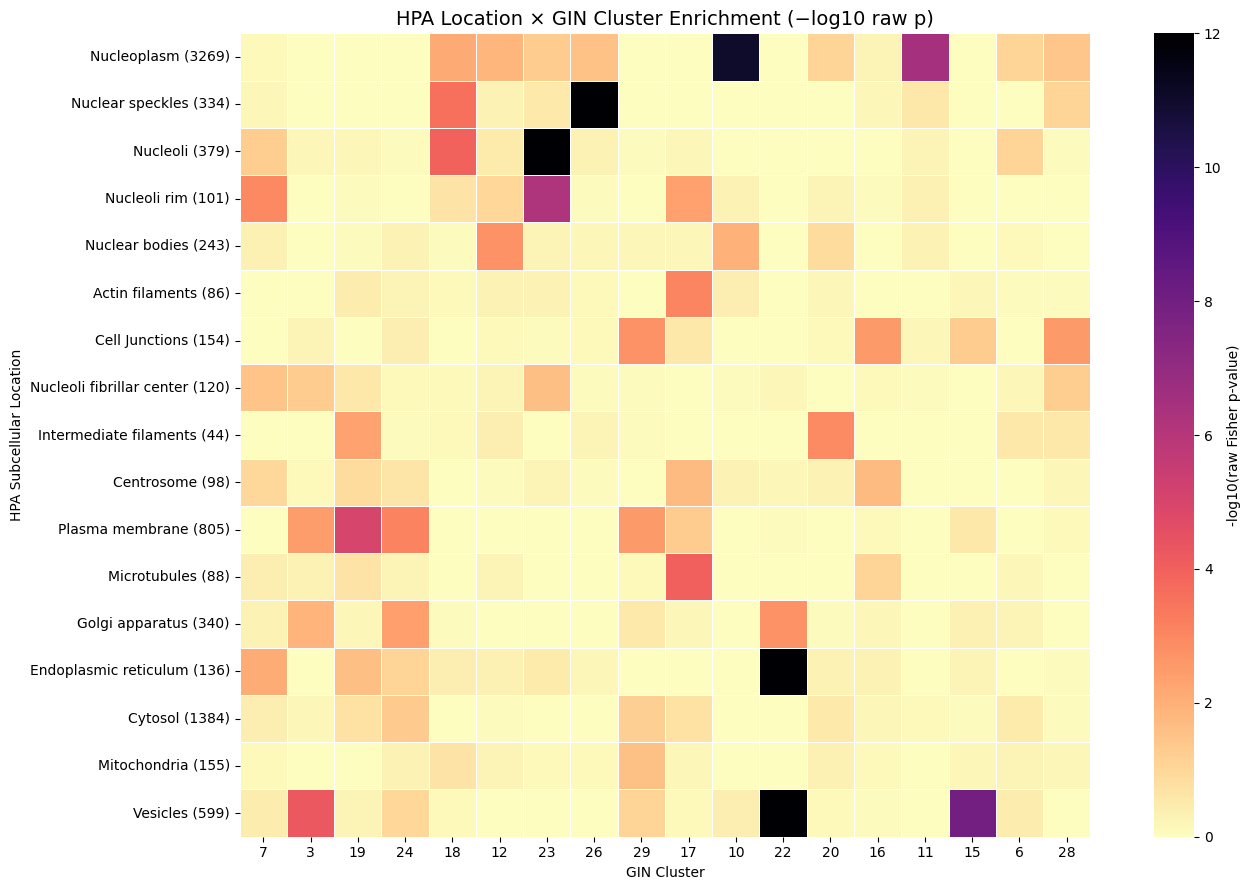

In [6]:
cmap = plt.cm.get_cmap("magma_r").copy()  # low=light orange, high=deep purple

plt.figure(figsize=(14,9))
ax = sns.heatmap(
    pivot,
    cmap=cmap,
    vmin=0, vmax=12,                  # show full range (no masking)
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "-log10(raw Fisher p-value)"},
)

plt.title("HPA Location × GIN Cluster Enrichment (−log10 raw p)", fontsize=14)
plt.xlabel("GIN Cluster"); plt.ylabel("HPA Subcellular Location")

cb = ax.collections[0].colorbar
cb.set_ticks([0,2,4,6,8,10,12])

plt.tight_layout()
plt.show()


/var/folders/79/r1nvfghs1wxf0hgqvgdnjtkh0000gn/T/ipykernel_5431/1730746588.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("magma_r").copy()


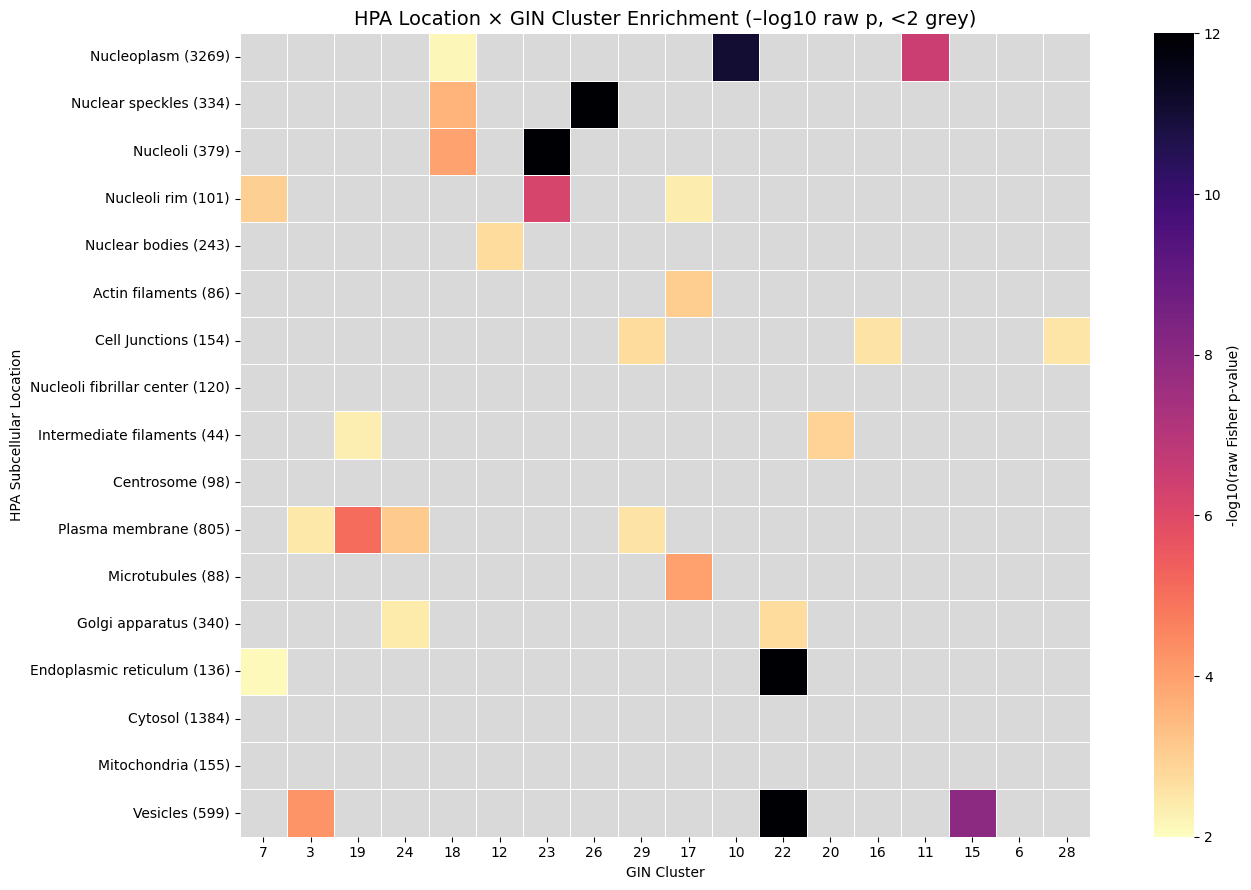

In [7]:
# make a copy so we don't overwrite pivot
data = pivot.copy()

# mask values < 2 (set to NaN so heatmap colors them grey)
data[data < 2] = np.nan

# colormap: orange → purple, and grey for NaNs
cmap = plt.cm.get_cmap("magma_r").copy()
cmap.set_bad("#D9D9D9")

plt.figure(figsize=(14,9))
ax = sns.heatmap(
    data,
    cmap=cmap,
    vmin=2, vmax=12,                  # scale from 2 to 12
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "-log10(raw Fisher p-value)"},
)

plt.title("HPA Location × GIN Cluster Enrichment (–log10 raw p, <2 grey)", fontsize=14)
plt.xlabel("GIN Cluster"); plt.ylabel("HPA Subcellular Location")

cb = ax.collections[0].colorbar
cb.set_ticks([2,4,6,8,10,12])

plt.tight_layout()
plt.show()


Summary of fishers exact test example 

In [10]:
# 1) What location labels do we actually have?
print(df["location"].sort_values().unique()[:50])
print(df["location"].value_counts().head(20))

# 2) Check counts for the label you used vs likely intended one
for lbl in ["Nucleolus", "Nucleoli"]:
    sub = df[df["location"].str.strip().str.casefold() == lbl.casefold()]
    print(lbl, "rows:", len(sub), "clusters present:", sorted(sub["Cluster Number"].unique())[:12])

# 3) If the intended label is Nucleoli (plural), rerun the summary for that
odds, p, table = fisher_summary(df, location="Nucleoli", cluster=23)

# 4) If you want to be robust to label variants, normalize labels first:
loc_map = {
    "nucleoli": "Nucleoli",
    "nucleolus": "Nucleoli",
    "nucleoli rim": "Nucleoli rim",
    "nucleoli fibrillar center": "Nucleoli fibrillar center",
    # add other canonicalizations as needed
}
df = df.assign(
    location=df["location"].astype(str).str.strip().str.casefold().map(loc_map).fillna(df["location"])
)

# Then rerun:
odds, p, table = fisher_summary(df, location="Nucleoli", cluster=23)


['Actin filaments' 'Cell Junctions' 'Centriolar satellite' 'Centrosome'
 'Cytokinetic bridge' 'Cytoplasmic bodies' 'Cytosol'
 'Endoplasmic reticulum' 'Endosomes' 'Focal adhesion sites'
 'Golgi apparatus' 'Intermediate filaments' 'Kinetochore' 'Lipid droplets'
 'Lysosomes' 'Microtubule ends' 'Microtubules' 'Midbody' 'Midbody ring'
 'Mitochondria' 'Mitotic chromosome' 'Mitotic spindle' 'Nuclear bodies'
 'Nuclear membrane' 'Nuclear speckles' 'Nucleoli'
 'Nucleoli fibrillar center' 'Nucleoli rim' 'Nucleoplasm' 'Peroxisomes'
 'Plasma membrane' 'Rods & Rings' 'Vesicles']
location
Nucleoplasm                  3269
Cytosol                      1384
Plasma membrane               805
Vesicles                      599
Nucleoli                      379
Golgi apparatus               340
Nuclear speckles              334
Nuclear bodies                243
Mitochondria                  155
Cell Junctions                154
Endoplasmic reticulum         136
Nuclear membrane              124
Nucleoli fi